In [2]:
###############################################################################
#                          1. Importing Libraries                             #
###############################################################################
# Visual bar for data generation
from tqdm.notebook import tqdm
import pickle
import os

# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Classifiers
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
path_real_dataset='/home/emmanuel/Dropbox/Statistics/DataAnalysis/NS_Simulations_554.dat' 
path_artificial_4fits='/home/emmanuel/Dropbox/Statistics/DataAnalysis/Generated_NS_Dataset_7480points.dat' 
# path_artificial_4fits='/home/emmanuel/Dropbox/Statistics/DataAnalysis/Generated_NS_Dataset_2620points.dat' #Less points
path_artificial_13fits='/home/emmanuel/Dropbox/Statistics/DataAnalysis/Generated_NS_Dataset_2048points.dat' 

real_data = pd.read_csv(path_real_dataset)
real_data = real_data.astype(float)
real_data = real_data.dropna()
# artificial_data_4 = pd.read_csv(path_artificial_4fits)
# artificial_data_4 = artificial_data_4.astype(float)
# artificial_data_4 = artificial_data_4.dropna()
artificial_data_13 = pd.read_csv(path_artificial_13fits)
artificial_data_13 = artificial_data_13.astype(float)
artificial_data_13 = artificial_data_13.dropna()

data=artificial_data_13# dataframe to train
#We change 'final-mass' to Erad to see what happens
data[["Erad"]]=1-data[["final-mass"]]

In [14]:
# Separate into the features and target variable
x = data[["initial_m1", "e","initial-separation","#orbits" ]] #, "initial_m2", "L0", "w022", , "peak-omega-22", "peak-ampl-22"]]
y = data[["final-mass"]]
# x2= data2[["initial_m1", "e","initial-separation","#orbits" ]] 
# y2= data2[["final-mass"]]
y = data[["Erad"]]
x.shape
# x2.shape

# X=pd.concat([x,x2],ignore_index=True)
# Y=pd.concat([y,y2],ignore_index=True)

(2048, 4)

In [15]:
# Normalize the dataframe first
# normed = x.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1000)

In [16]:
###############################################################################
#                               4. Regressors                                #
###############################################################################
# Create list of tuples with classifier label and classifier object
regressors = {}
#regressors.update({"SVR": SVR()})
# regressors.update({"Linear Regression": LinearRegression()})
# regressors.update({"Ridge": Ridge()})
#regressors.update({"MLP": MLPRegressor()})
regressors.update({"Random Forest": RandomForestRegressor()})
#regressors.update({"Elastic Net": ElasticNet()})
# regressors.update({"Gradient Boosting": GradientBoostingRegressor()})

###############################################################################
#                             5. Hyper-parameters                             #
###############################################################################
# Initiate parameter grid
parameters = {}

# Update dict with Linear Regression
parameters.update({"Linear Regression": {}})

# Update dict with SVR
parameters.update({"SVR": {
                            "classifier__C": [0.5, 1, 2, 5, 10],
                            "classifier__shrinking": [True, False],
                            "classifier__degree": [1, 2, 3, 5, 10],
}})

# Update dict with Ridge Regression
parameters.update({"Ridge": {
                            "classifier__alpha": [0.5, 1, 2, 5, 10],
                            "classifier__solver": ['auto', 'svd', "cholesky", 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
}})

# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "classifier__learning_rate":[0.15, 0.1, 0.05], 
                                        "classifier__n_estimators": [200],
                                        "classifier__max_depth": [4,6],
                                        "classifier__min_samples_split": [0.07],
                                        "classifier__min_samples_leaf": [0.7],
                                        "classifier__max_features": ["auto"],
                                        "classifier__subsample": [0.8, 1]
}})

# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [100, 200, 300],
                                    "classifier__max_features": ["auto"],
                                    "classifier__max_depth" : [3, 5, 7, 8],
                                    "classifier__min_samples_split": [0.005, 0.01, 0.05],
                                    "classifier__min_samples_leaf": [0.005, 0.01, 0.05],
                                    "classifier__criterion" :["squared_error", "absolute_error", "poisson"],
                                    "classifier__n_jobs": [-1]
                                     }})

# Update dict with MLPClassifier
parameters.update({"MLP": { 
                            "classifier__hidden_layer_sizes": [(25), (12), (12, 12)],
                            "classifier__activation": ["tanh", "relu"],
                            "classifier__learning_rate": ["constant", "adaptive"],
                            "classifier__max_iter": [100],
                            "classifier__alpha": list(10.0 ** -np.arange(5, 10)),
                             }})

# Update dict with Elastic Net
parameters.update({"Elastic Net": { 
                            "classifier__alpha": [0.5, 1, 2, 5, 10],
                            "classifier__warm_start": [True, False],
                            "classifier__selection": ["cyclic", "random"],
                             }})

In [17]:
###############################################################################
#                       13. Classifier Tuning and Evaluation                  #
###############################################################################
# Initialize dictionary to store results
results = {}
num_models = 0

# Tune and evaluate classifiers
for classifier_label, classifier in regressors.items():
    # Print message to user
    print(f"Now tuning {classifier_label}.")
    
    try:
        # Scale features via Z-score normalization
#         scaler = StandardScaler()

        # Define steps in pipeline
#         steps = [("scaler", scaler), ("classifier", classifier)]
        steps = [("classifier", classifier)]

        # Initialize Pipeline object
        pipeline = Pipeline(steps = steps)

        # Define parameter grid
        param_grid = parameters[classifier_label]

        # Initialize GridSearch object
        gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= 8, verbose = 1, scoring = "r2")

        # Fit gscv
        gscv.fit(X_train, np.ravel(y_train))  

        # Get best parameters and score
        best_params = gscv.best_params_
        best_score = gscv.best_score_

        # Update classifier parameters and define new pipeline with tuned classifier
        tuned_params = {item[12:]: best_params[item] for item in best_params}
        classifier.set_params(**tuned_params)

        # Make predictions
        y_pred = gscv.predict(X_test)
    
        # Evaluate model
#         auc = metrics.roc_auc_score(y_test, y_pred)
#         r2 = gscv.score(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        # Save results
        result = {"Regressor": gscv,
                  "Best Parameters": best_params,
                  "Training AUC": best_score,
                  "Test AUC": r2,
                  "Test MSE": mse}

        results.update({classifier_label: result})
    except e:
        print(e)
        print("Model {} had an error, skipping.".format(classifier_label))
        
print("Complete!")

Now tuning Random Forest.
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
432 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
432 fits failed with the following error:
Traceback (most recent call last):
  File "/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 355, in fit
    raise ValueEr

Complete!


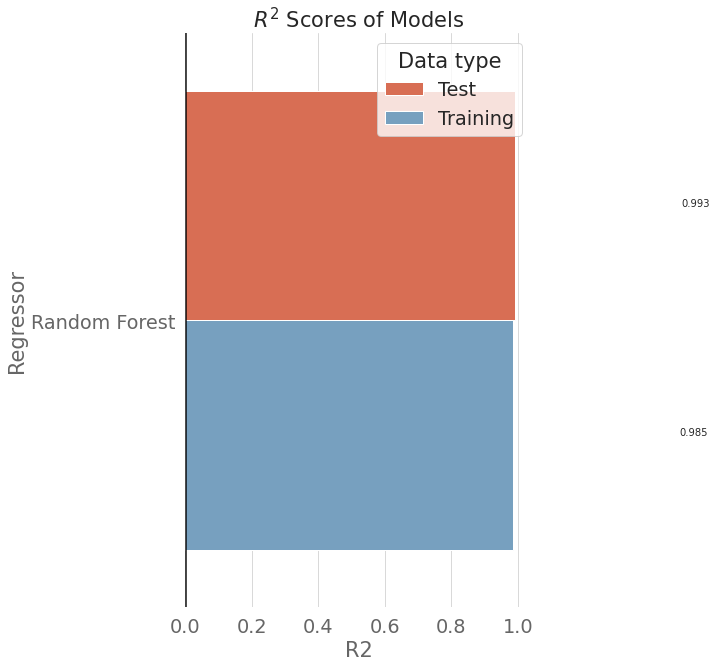

In [18]:
###############################################################################
#                              14. Visualing Results                          #
###############################################################################
# Initialize auc_score dictionary
auc_scores = {
              "Regressor": [],
              "R2": [],
              "Data type": []
              }

# Get AUC scores into dictionary
for classifier_label in results:
    auc_scores.update({"Regressor": [classifier_label] + auc_scores["Regressor"],
                       "R2": [results[classifier_label]["Training AUC"]] + auc_scores["R2"],
                       "Data type": ["Training"] + auc_scores["Data type"]})
    
    auc_scores.update({"Regressor": [classifier_label] + auc_scores["Regressor"],
                       "R2": [results[classifier_label]["Test AUC"]] + auc_scores["R2"],
                       "Data type": ["Test"] + auc_scores["Data type"]})

# Dictionary to PandasDataFrame
auc_scores = pd.DataFrame(auc_scores)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

    
# Colors
training_color = sns.color_palette("RdYlBu", 10)[1]
test_color = sns.color_palette("RdYlBu", 10)[-2]
colors = [training_color, test_color]

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

p = sns.barplot(x="R2", y="Regressor", hue="Data type", palette = colors, data=auc_scores)
show_values(p, "h", space=0.5)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.title('$R^2$ Scores of Models')
plt.savefig("R2scores.png", dpi = 1080)
plt.show()

In [19]:
# Initialize auc_score dictionary
mse_scores = {
              "Regressor": [],
              "MSE": [],
              }

# Get MSE scores into dictionary
for classifier_label in results:
    mse_scores.update({"Regressor": [classifier_label] + mse_scores["Regressor"],
                       "MSE": [results[classifier_label]["Test MSE"]] + mse_scores["MSE"]})
# Best MSE scores found for the models
for model, mse in zip(mse_scores["Regressor"], mse_scores["MSE"]):
    print(f"{model:20}: {mse}")

Random Forest       : 9.929325929316586e-07


In [20]:
# Using best found parameters, refit the model to the training data
best_rf_params = dict()
for key, value in results['Random Forest']['Best Parameters'].items():
    best_rf_params[key.replace('classifier__', '')] = value
print(best_rf_params)

rf_regressor = RandomForestRegressor()
rf_regressor.set_params(**best_rf_params)
rf_regressor = rf_regressor.fit(X_train, np.ravel(y_train))


{'criterion': 'absolute_error', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 300, 'n_jobs': -1}


In [21]:
#Save model
import joblib
joblib.dump(rf_regressor, "./rf_regressor_generated_NS_Dataset_2048points.joblib")
#To load loaded_rf = joblib.load("./random_forest.joblib")

['./rf_regressor_Erad_generated_NS_Dataset_2048points.joblib']

# Predictions with real dataset

In [29]:
#Use this cell when working with the real dataset
column1,column2,column3='e','final-mass','initial_m1'

separation_classes=np.unique(round(data['initial-separation'],0).values)
column3_classes=np.unique(data[column3].values)

sep0=separation_classes[3]#small separation = separation_classes[3]
sep1=separation_classes[-1]
initial_mass=column3_classes[-1]

fixed_parameter=data[data[column3]==initial_mass]
fixed_parameter=fixed_parameter[fixed_parameter[column2]>0.92]#filter one point with non usual final-mass 
fixed_parameter=fixed_parameter.sort_values(column1)

fixed_sep0=fixed_parameter[round(fixed_parameter['initial-separation'],0)==sep0]
fixed_sep1=fixed_parameter[round(fixed_parameter['initial-separation'],1)==24.6]

In [37]:
np.unique(round(data['initial-separation'],1).values)

array([11. , 24.6])

In [96]:
# And predict on new data                                
def prediction(fixed_sep1,e=-1,sep=0,no_orbits=0,column_to_append='e',initial_mass=-1):
    x_axis=[]
    prediction=[]
    if initial_mass!=-1:
        if (sep!=0 and no_orbits!=0):
            if e==-1:
                for index, row in fixed_sep1.iterrows():
                    x_axis.append(row[column_to_append])
                    prediction.append(rf_regressor.predict([[initial_mass, row['e'], sep ,no_orbits]]))
            else:
                for index, row in fixed_sep1.iterrows():
                    x_axis.append(row[column_to_append])
                    prediction.append(rf_regressor.predict([[initial_mass, e, sep ,no_orbits]]))
        elif (sep!=0 and no_orbits==0):
            if e==-1:
                for index, row in fixed_sep1.iterrows():
                    x_axis.append(row[column_to_append])
                    prediction.append(rf_regressor.predict([[initial_mass, row['e'], sep ,row['#orbits']]]))
            else:
                for index, row in fixed_sep1.iterrows():
                    x_axis.append(row[column_to_append])
                    prediction.append(rf_regressor.predict([[initial_mass, e, sep ,row['#orbits']]]))        

        elif (sep==0 and no_orbits!=0):
            if e==-1:
                for index, row in fixed_sep1.iterrows():
                    x_axis.append(row[column_to_append])
                    prediction.append(rf_regressor.predict([[initial_mass, row['e'], row['initial-separation'] ,no_orbits]]))
            else:
                for index, row in fixed_sep1.iterrows():
                    x_axis.append(row[column_to_append])
                    prediction.append(rf_regressor.predict([[initial_mass, e, row['initial-separation'] ,no_orbits]]))       
        else:
            if e==-1:
                for index, row in fixed_sep1.iterrows():
                    x_axis.append(row[column_to_append])
                    prediction.append(rf_regressor.predict([[initial_mass, row['e'], row['initial-separation'],row['#orbits']]]))
            else:
                for index, row in fixed_sep1.iterrows():
                    x_axis.append(row[column_to_append])
                    prediction.append(rf_regressor.predict([[initial_mass, e, row['initial-separation'],row['#orbits']]]))
    elif (initial_mass==-1):
            if (sep!=0 and no_orbits!=0):
                if e==-1:
                    for index, row in fixed_sep1.iterrows():
                        x_axis.append(row[column_to_append])
                        prediction.append(rf_regressor.predict([[row['initial_m1'], row['e'], sep ,no_orbits]]))
                else:
                    for index, row in fixed_sep1.iterrows():
                        x_axis.append(row[column_to_append])
                        prediction.append(rf_regressor.predict([[row['initial_m1'], e, sep ,no_orbits]]))
            elif (sep!=0 and no_orbits==0):
                if e==-1:
                    for index, row in fixed_sep1.iterrows():
                        x_axis.append(row[column_to_append])
                        prediction.append(rf_regressor.predict([[row['initial_m1'], row['e'], sep ,row['#orbits']]]))
                else:
                    for index, row in fixed_sep1.iterrows():
                        x_axis.append(row[column_to_append])
                        prediction.append(rf_regressor.predict([[row['initial_m1'], e, sep ,row['#orbits']]]))        

            elif (sep==0 and no_orbits!=0):
                if e==-1:
                    for index, row in fixed_sep1.iterrows():
                        x_axis.append(row[column_to_append])
                        prediction.append(rf_regressor.predict([[row['initial_m1'], row['e'], row['initial-separation'] ,no_orbits]]))
                else:
                    for index, row in fixed_sep1.iterrows():
                        x_axis.append(row[column_to_append])
                        prediction.append(rf_regressor.predict([[row['initial_m1'], e, row['initial-separation'] ,no_orbits]]))       
            else:
                if e==-1:
                    for index, row in fixed_sep1.iterrows():
                        x_axis.append(row[column_to_append])
                        prediction.append(rf_regressor.predict([[row['initial_m1'], row['e'], row['initial-separation'],row['#orbits']]]))
                else:
                    for index, row in fixed_sep1.iterrows():
                        x_axis.append(row[column_to_append])
                        prediction.append(rf_regressor.predict([[row['initial_m1'], e, row['initial-separation'],row['#orbits']]]))

    return x_axis,np.ravel(prediction)


/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/

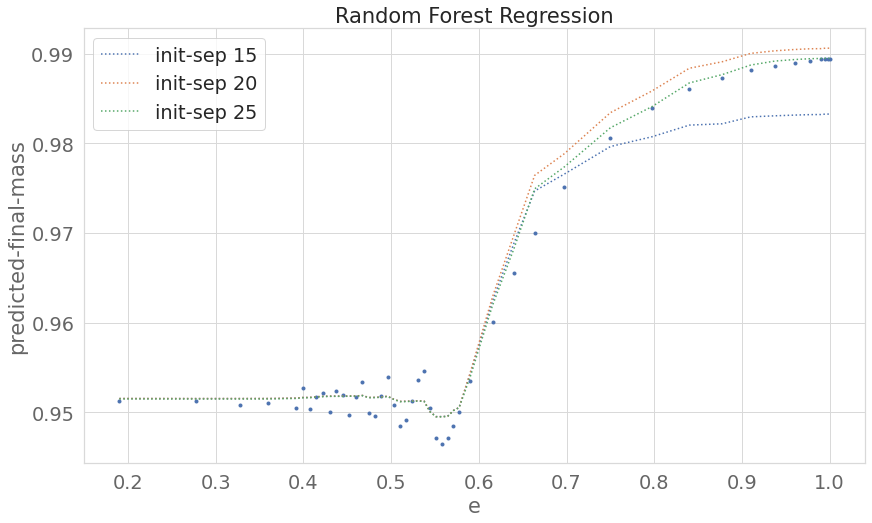

In [107]:
#data
plt.figure(figsize=(14, 8))
plt.scatter(fixed_sep1['e'].values, fixed_sep1['final-mass'].values,marker='.')
#plt.scatter(fixed_sep0['e'].values, fixed_sep0['final-mass'].values,marker='.')
#predictions on initial-separation 24.6
for i in range(15,30,5):
    x_to_plot,y_to_plot=prediction(fixed_sep1,sep=i)
    plt.plot(x_to_plot,y_to_plot,ls='dotted',label='init-sep '+str(i))
plt.title("Random Forest Regression")
plt.ylabel("predicted-final-mass")
plt.xlabel("e")
plt.legend()
plt.savefig('RFR_e_vs_final-mass_fixed_m1-s.png')

/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/

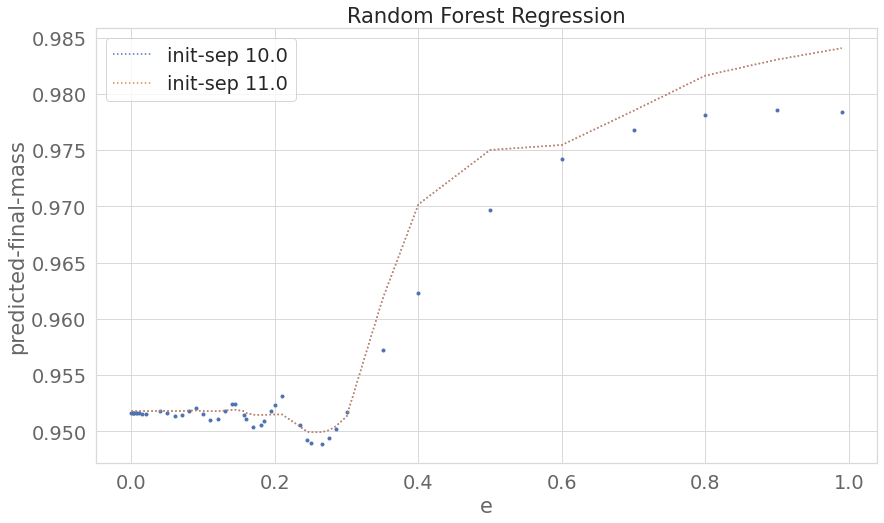

In [105]:
#data
plt.figure(figsize=(14, 8))
plt.scatter(fixed_sep0['e'].values, fixed_sep0['final-mass'].values,marker='.')
#predictions on initial-separation 11
for i in np.arange(10.,11.1,1):
    x_to_plot,y_to_plot=prediction(fixed_sep0,sep=i)
    plt.plot(x_to_plot,y_to_plot,ls='dotted',label='init-sep '+str(i))
plt.title("Random Forest Regression")
plt.ylabel("predicted-final-mass")
plt.xlabel("e")
plt.legend()
plt.show()

In [78]:
e_values=np.unique(round(data['e'],2).values)
m1_values=np.unique(round(data['initial_m1'],2).values)
orbit_values=np.unique(round(data['#orbits'],0).values)
e_no_classes=[len(data[round(data['e'],2)==e]) for e in e_values]
m0_no_classes=[len(data[round(data['initial_m1'],2)==initial_m1]) for initial_m1 in m1_values]
orbits_no_classes=[len(data[round(data['#orbits'],0)==o]) for o in orbit_values]
print(e_values)
print(e_no_classes)
print(m1_values)
print(m0_no_classes)
print(orbit_values)
print(orbits_no_classes)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.3  0.33 0.35 0.36 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47
 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.62
 0.64 0.65 0.66 0.7  0.75 0.8  0.84 0.88 0.9  0.91 0.94 0.96 0.98 0.99
 1.  ]
[39, 12, 8, 3, 4, 4, 6, 4, 6, 4, 6, 4, 6, 4, 7, 3, 7, 4, 7, 14, 7, 4, 5, 3, 7, 4, 1, 3, 3, 4, 1, 4, 12, 1, 5, 2, 1, 1, 13, 2, 1, 13, 1, 1, 6, 14, 3, 1, 3, 12, 3, 1, 15, 1, 4, 12, 14, 1, 12, 16, 14, 16, 14, 12, 4, 14, 12, 14, 12, 18, 38]
[0.01 0.02 0.03 0.06 0.09 0.12 0.14 0.17 0.2  0.25 0.29 0.33 0.36 0.38
 0.4  0.41 0.43 0.44 0.45 0.46 0.47 0.48 0.5 ]
[1, 2, 13, 13, 1, 24, 24, 25, 91, 24, 25, 64, 1, 24, 1, 23, 41, 23, 1, 1, 22, 1, 92]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 18.
 20. 21. 24. 32. 33. 34. 35. 38. 40. 43. 47. 61.]
[123, 137, 38, 21, 33, 24, 23, 18, 28, 27, 16, 8, 7, 10, 4, 1, 2, 2, 1, 3, 

In [92]:
fixed_e=data[round(data['e'],2)==e_values[-1]]
fixed_e=fixed_e.sort_values('initial_m1')
fixed_e=fixed_e[round(fixed_e['initial-separation'],1)==24.6]
fixed_orbits=data[round(data['#orbits'],0)==orbit_values[2]]
fixed_orbits=fixed_orbits.sort_values('e')

/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/

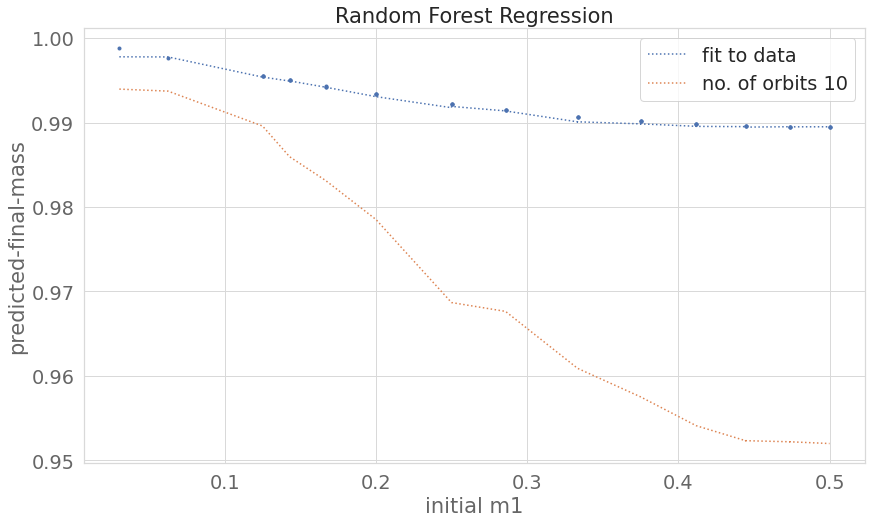

In [126]:
#data
plt.figure(figsize=(14, 8))
plt.scatter(fixed_e['initial_m1'].values, fixed_e['final-mass'].values,marker='.')
x_to_plot,y_to_plot=prediction(fixed_e,column_to_append='initial_m1')
plt.plot(x_to_plot,y_to_plot,ls='dotted',label='fit to data') #Variable number of orbits

#for i in np.arange(0,10,5):
i=10 #can only extend to 10
x_to_plot,y_to_plot=prediction(fixed_e,no_orbits=i,column_to_append='initial_m1')
plt.plot(x_to_plot,y_to_plot,ls='dotted',label='no. of orbits '+str(i))

plt.title("Random Forest Regression")
plt.ylabel("predicted-final-mass")
plt.xlabel("initial m1")
plt.legend()
plt.savefig('RFR_initial_m1_vs_final-mass_fixed_o.png')

/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/

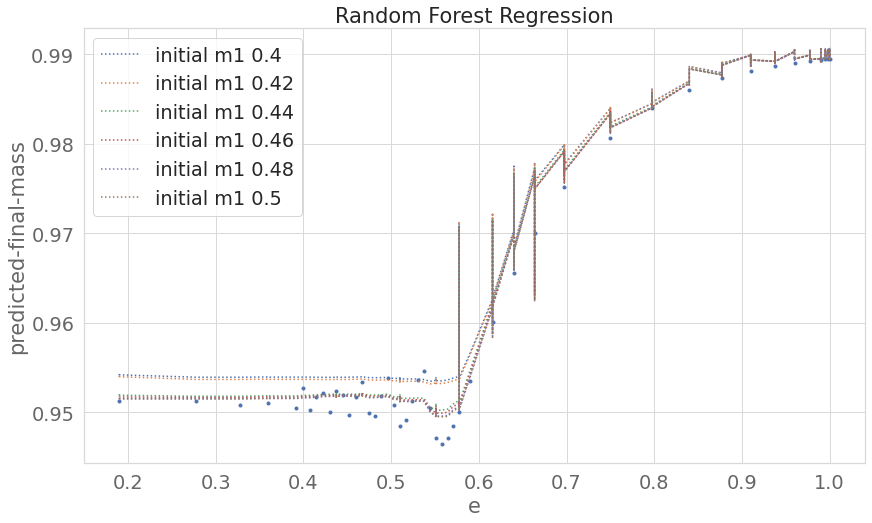

In [124]:
#data
fixed_sep=data[round(data['initial-separation'],1)==24.6]
fixed_sep=fixed_sep.sort_values('e')
plt.figure(figsize=(14, 8))
plt.scatter(fixed_sep1['e'].values, fixed_sep1['final-mass'].values,marker='.')
#predictions on initial-separation 11
for i in np.arange(0.40,0.51,0.02):
    x_to_plot,y_to_plot=prediction(fixed_sep,initial_mass=i)
    plt.plot(x_to_plot,y_to_plot,ls='dotted',label='initial m1 '+str(round(i,2)))
plt.title("Random Forest Regression")
plt.ylabel("predicted-final-mass")
plt.xlabel("e")
plt.legend()
plt.savefig('RFR_e_vs_final-mass_fixed_s.png')

/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/

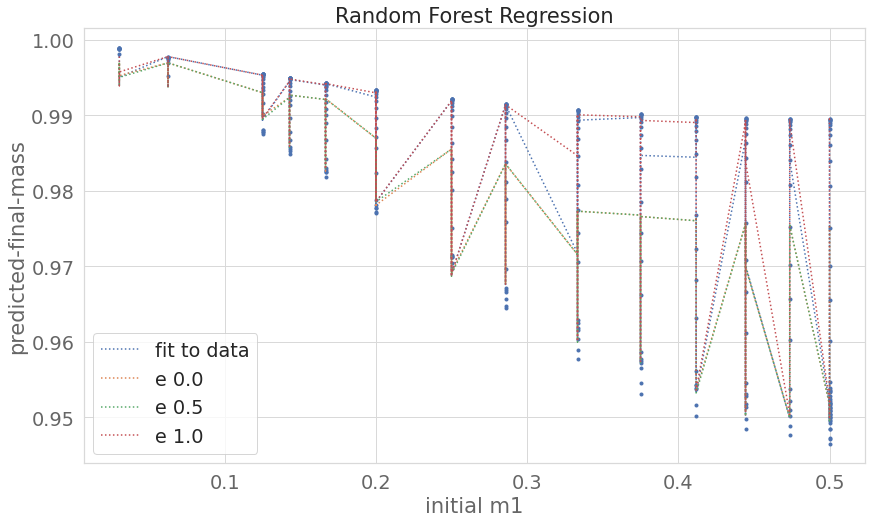

In [146]:
#data
plt.figure(figsize=(14, 8))
fixed_sep=data[round(data['initial-separation'],1)==24.6]
fixed_sep=fixed_sep.sort_values('initial_m1')
plt.scatter(fixed_sep['initial_m1'].values, fixed_sep['final-mass'].values,marker='.')
x_to_plot,y_to_plot=prediction(fixed_sep,column_to_append='initial_m1')
plt.plot(x_to_plot,y_to_plot,ls='dotted',label='fit to data') #Variable number of orbits

for i in np.arange(0,1.01,0.5):
    x_to_plot,y_to_plot=prediction(fixed_sep,e=i,column_to_append='initial_m1')
    plt.plot(x_to_plot,y_to_plot,ls='dotted',label='e '+str(round(i,1)))

plt.title("Random Forest Regression")
plt.ylabel("predicted-final-mass")
plt.xlabel("initial m1")
plt.legend()
plt.savefig('RFR_initial_m1_vs_final-mass_fixed_s.png')

/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/emmanuel/

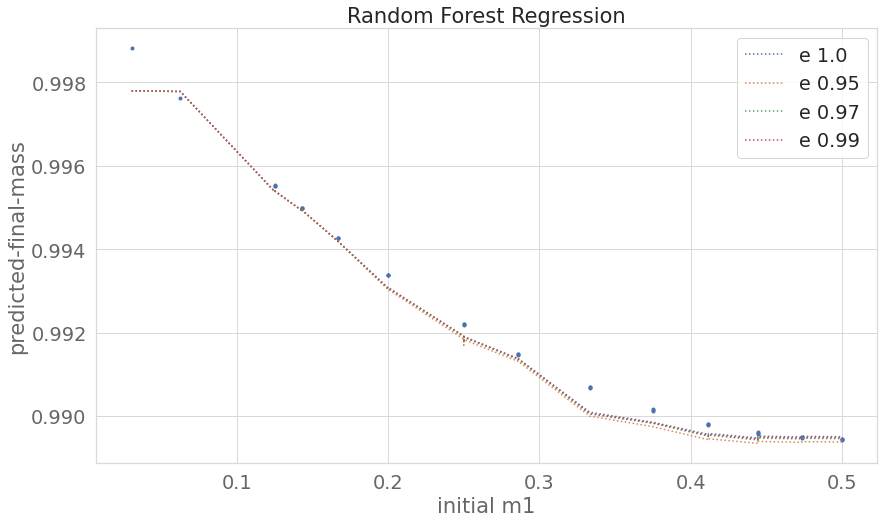

In [145]:
#data
plt.figure(figsize=(14, 8))
fixed_sep=data[round(data['initial-separation'],1)==24.6]
fixed_sep=fixed_sep.sort_values('initial_m1')
fixed_sep=fixed_sep[round(fixed_sep['e'],2)==1.]
plt.scatter(fixed_sep['initial_m1'].values, fixed_sep['final-mass'].values,marker='.')
x_to_plot,y_to_plot=prediction(fixed_sep,column_to_append='initial_m1')
plt.plot(x_to_plot,y_to_plot,ls='dotted',label='e 1.0') #Variable number of orbits

for i in np.arange(0.95,1.0,0.02):
    x_to_plot,y_to_plot=prediction(fixed_sep,e=i,column_to_append='initial_m1')
    plt.plot(x_to_plot,y_to_plot,ls='dotted',label='e '+str(round(i,2)))

plt.title("Random Forest Regression")
plt.ylabel("predicted-final-mass")
plt.xlabel("initial m1")
plt.legend()
plt.savefig('RFR_initial_m1_vs_final-mass_fixed_s-e.png')

# Predictions with generated dataset

## Load Data

In [1]:
import joblib
#rf_regressor = joblib.load("rf_regressor_generated_NS_Dataset_7480points.joblib")
rf_regressor = joblib.load("./rf_regressor_generated_NS_Dataset_2048points.joblib")
# rf_regressor = joblib.load("./rf_regressor_generated_NS_Dataset_7480points+real_dataset.joblib")

## Separate data

In [4]:
#Use this cell when working with the generated dataset
column1,column2,column3='e','final-mass','initial_m1'
# data=data2
data=data.sort_values(column1)

separation_classes=np.unique(round(data['initial-separation'],1).values)
column3_classes=np.unique(data[column3].values)
print(column3_classes)

sep11=separation_classes[0]#small separation = separation_classes[3]
sep246=separation_classes[1]
initial_m20,initial_m41,initial_m43,initial_m50=0.2,0.41,0.43,0.5

fixed_m50=data[data[column3]==initial_m50]
fixed_m41=data[data[column3]==initial_m41]
fixed_m43=data[data[column3]==initial_m43]
fixed_m20=data[data[column3]==initial_m20]
#fixed_parameter=fixed_parameter[fixed_parameter[column2]>0.92]#filter one point with non usual final-mass 

fixed_sep11_m50=fixed_m50[round(fixed_m50['initial-separation'],0)==sep11]
fixed_sep25_m41=fixed_m41[round(fixed_m41['initial-separation'],1)==sep246]
fixed_sep11_m43=fixed_m43[round(fixed_m43['initial-separation'],0)==sep11]
fixed_sep11_m20=fixed_m20[round(fixed_m20['initial-separation'],0)==sep11]
fixed_sep246_m50=fixed_m50[round(fixed_m50['initial-separation'],1)==sep246]

[0.12 0.14 0.17 0.2  0.25 0.29 0.33 0.38 0.41 0.43 0.44 0.5 ]


## Predictions generation

In [8]:
def plot(x,prediction,y=None,x_name='e',y_name='final mass',name_to_save=None):
    fig, axs = plt.subplots(1,1,figsize=(14,8))
    axs.grid(True)
    if type(y)==np.ndarray: plt.scatter(x, y ,marker='.',label='dataset')
    
    plt.plot(x, prediction,ls='dotted',c='crimson',label='predicted curve')
    
    plt.title(x_name+' vs '+y_name+' Random Forest predictions')
    axs.legend(loc='best')
    axs.set_xlabel(x_name)
    axs.set_ylabel(y_name)
    
    if name_to_save: 
        plt.savefig(name_to_save+'.png')
    else:
        plt.show()
    return

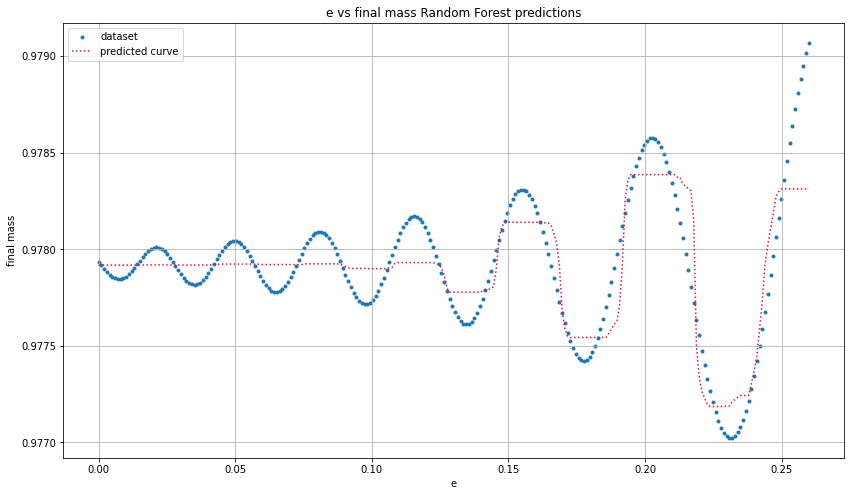

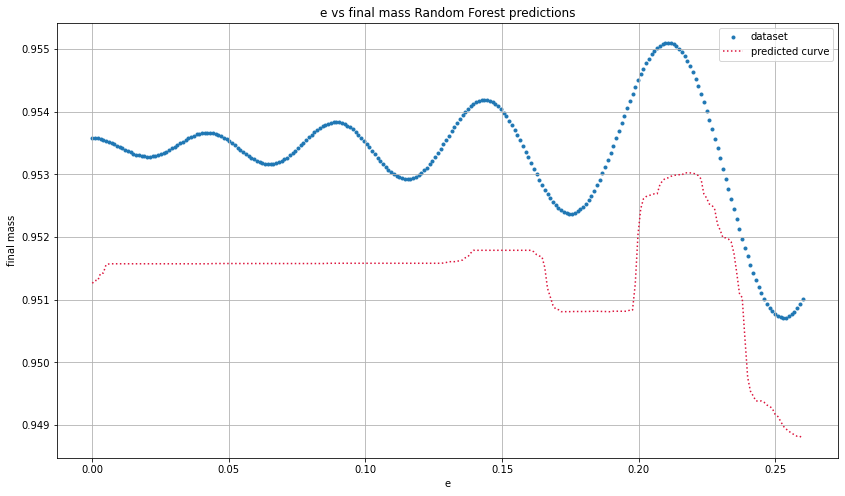

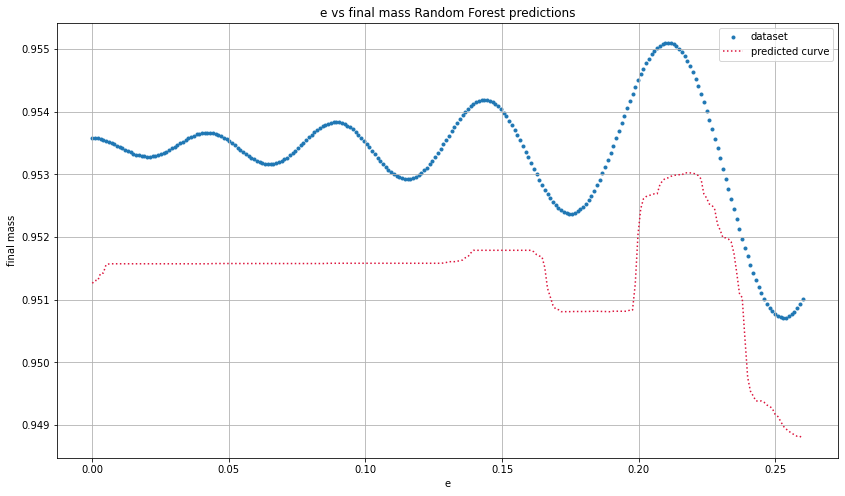

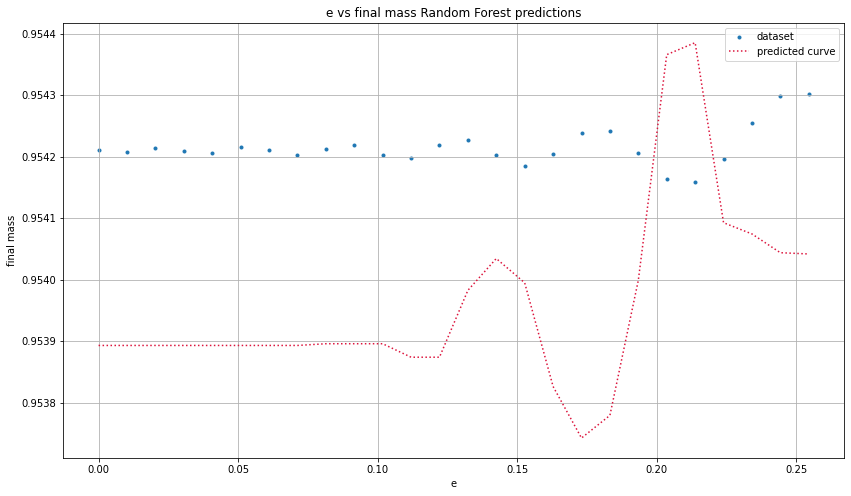

In [10]:
# And predict on new data                                
x_axis=[]
list_s12_m20=[]
list_s11_m44=[]
list_s11_m45=[]
list_s11_m41=[]

#Construct lists with new parameters
for index, row in fixed_sep11_m20.iterrows():
    list_s12_m20.append([row['initial_m1'], row['e'], 12 ,row['#orbits']])

for index, row in fixed_sep11_m43.iterrows():
    list_s11_m44.append([0.44, row['e'], row['initial-separation'],row['#orbits']])

for index, row in fixed_sep11_m43.iterrows():
    list_s11_m45.append([0.45, row['e'], row['initial-separation'],row['#orbits']])

fixed_sep25_m41=fixed_sep25_m41[fixed_sep25_m41['e']<=0.26]
for index, row in fixed_sep25_m41.iterrows():
    list_s11_m41.append([row['initial_m1'], row['e'], 11 ,row['#orbits']])

#Do predictions on the new lists    
df_s12_m20=pd.DataFrame(list_s12_m20,columns=['initial_m1','e','initial-separation','#orbits'])
prediction_s12_m20=rf_regressor.predict(df_s12_m20)

df_s11_m44=pd.DataFrame(list_s11_m44,columns=['initial_m1','e','initial-separation','#orbits'])
prediction_s11_m44=rf_regressor.predict(df_s11_m44)

df_s11_m45=pd.DataFrame(list_s11_m45,columns=['initial_m1','e','initial-separation','#orbits'])
prediction_s11_m45=rf_regressor.predict(df_s11_m45)

df_s11_m41=pd.DataFrame(list_s11_m41,columns=['initial_m1','e','initial-separation','#orbits'])
prediction_s11_m41=rf_regressor.predict(df_s11_m41)


#Plot results
plot(fixed_sep11_m20['e'].values,np.ravel(prediction_s12_m20),fixed_sep11_m20['final-mass'].values,x_name='e',y_name='final mass')
plot(fixed_sep11_m43['e'].values,np.ravel(prediction_s11_m44),fixed_sep11_m43['final-mass'].values,x_name='e',y_name='final mass')
plot(fixed_sep11_m43['e'].values,np.ravel(prediction_s11_m45),fixed_sep11_m43['final-mass'].values,x_name='e',y_name='final mass')
plot(fixed_sep25_m41['e'].values,np.ravel(prediction_s11_m41),fixed_sep25_m41['final-mass'].values,x_name='e',y_name='final mass')


## Radiation comparisons

### s11,m45

In [ ]:
index=np.where(prediction_s12_m20 == np.min(prediction_s12_m20))[0]
min_e=df_s11_m45['e'][index].values[0]

print('Point of maximum radiation for m1_0=0.45,s_0=11. : E_rad=',1-np.min(prediction_s12_m20),' achieved at e=',min_e)

Point of maximum radiation for m1_0=0.45,s_0=11. : E_rad= 0.02281378062862638  achieved at e= 0.2238610038610038


In [18]:
Average_m45=np.mean(rf_regressor.predict(df_s11_m45.iloc[:,:]))
print('Average radiation on m1=0.45, s=11:',Average_m45)

Average radiation on m1=0.45, s=11: 0.9514445924536822


In [17]:
df_s11_m45.iloc[0:2,:]

,initial_m1,e,initial-separation,#orbits
0,0.45,0.000000,11.0,8.925877
1,0.45,0.001004,11.0,8.892358


In [23]:
print('Delta average radiation',0.953407-0.951542)

Delta average radiation 0.0018650000000000055


In [30]:
#Prediction with after-fit
e_range=np.arange(0,0.26,0.005)
Mf=poly2_damped_oscillator(e_range,**best_value_param)
index=np.where(Mf == np.min(Mf))[0][0]
min_e=e_range[index]

print('Point of maximum radiation for m1_0=0.45,s_0=11. : E_rad=',1-np.min(Mf),' achieved at e=',min_e)

Point of maximum radiation for m1_0=0.45,s_0=11. : E_rad= 0.05130372879846401  achieved at e= 0.255


### s11,m41

In [31]:
index=np.where(prediction_s11_m41 == np.min(prediction_s11_m41))[0]
min_e=df_s11_m41['e'][index].values[0]

print('Point of maximum radiation for m1_0=0.45,s_0=11. : E_rad=',1-np.min(prediction_s11_m41),' achieved at e=',min_e)

Point of maximum radiation for m1_0=0.45,s_0=11. : E_rad= 0.04625755027851175  achieved at e= 0.1730909090909091


In [32]:
Average_m41=np.mean(rf_regressor.predict(df_s11_m41.iloc[:,:]))
print('Average radiation on m1=0.45, s=11:',Average_m41)

Average radiation on m1=0.45, s=11: 0.9539593210647163


## Comparison plots

In [19]:
def poly2_damped_oscillator(t,amplitude,f1,f2,phase,decay,k):#,amplitude2,frequency2,phase2,decay2
    return amplitude*np.exp(decay*t)*np.cos(f1*t+f2*t**2 + phase)+k

from lmfit import Model

def plot_with_fit(df,function, guess,x_axis='e',y_axis='final-mass',name_to_save=False):
    
    fig, axs = plt.subplots(1,1,figsize=(14,8))
    
    prediction=rf_regressor.predict(df)
    
    plt0=axs.scatter(df[x_axis], prediction,c=df['#orbits'],marker='.')
    dmodel=Model(function)
    params = dmodel.make_params(**guess)
    result = dmodel.fit(prediction, params, t=df[x_axis])
    print(result.best_values)

    mass_label=str(np.unique(round(df.loc[:,['initial_m1']],2))[0])
    s_label=str(np.unique(round(df.loc[:,['initial-separation']],0))[0])
    axs.plot(df[x_axis], function(df[x_axis],**result.best_values),ls='dotted',label='m1='+mass_label+',s0='+s_label)

    cb0=fig.colorbar(plt0,label="n orbits")
    axs.set_xlabel(x_axis)
    axs.set_ylabel(y_axis)
    plt.legend(loc='best')
    if name_to_save: 
        plt.savefig(name_to_save+'.png')
    else:
        plt.show()
    return result.best_values

In [20]:
def simple_plot(e_values,function,params_array,name_to_save=False,labels=['m1=0.43','m1=0.48','m1=0.50']):
    fig, axs = plt.subplots(1,1,figsize=(14,8))
    
    i=0
    for params in params_array: 
        axs.plot(e_values, function(e_values,**params),ls='dotted',label=labels[i])
        i+=1
        
    axs.set_xlabel("e")
    axs.set_ylabel("final-mass")
    plt.grid(True)
    plt.legend()
    if name_to_save: 
        plt.savefig(name_to_save+'.png')
    else:
        plt.show()
    return

In [21]:
m1o43_s11_params={'amplitude': 0.00013150421973126322, 'f1': -156.68262408285742, 'f2': 176.47536194648444, 'phase': 75.2942858916935, 'decay': 12.065270784666023, 'k': 0.9534501933215364}
m1o45_s11_params={'amplitude': 7.913662518879698e-05, 'f1': -166.99420006281872, 'f2': 202.9007095407067, 'phase': 75.8442624900419, 'decay': 14.503247296892962, 'k': 0.9534373479212499}
 # m1o48_s11_params={'amplitude': 2.0676110564135846e-05, 'f1': -158.78086230043604, 'f2': 178.9066015652532, 'phase': 75.48217768291566, 'decay': 19.70625970974119, 'k': 0.9515803386065128}
m1o50_s11_params={'amplitude': 0.00014887556639812068, 'f1': -154.7170957190035, 'f2': 174.87960460832457, 'phase': 74.97462188181812, 'decay': 11.520402722919949, 'k': 0.9515427928245563}
params_array=[m1o43_s11_params,best_value_param,m1o50_s11_params]
e_values=np.arange(0,0.25,0.01)
simple_plot(e_values,poly2_damped_oscillator,params_array,labels=['m1=0.43','m1=0.45','m1=0.50'])#,name_to_save='plot_fitted_model_m1_0.48_0.45_0.50_s0_11'

NameError: name 'best_value_param' is not defined

In [22]:
def check_with_real_data(test_df,function,params,name_to_save=False):
    fig, axs = plt.subplots(1,1,figsize=(14,8))
    e_values=np.arange(0,0.26,0.01)
    #real dataset plot
    axs.scatter(test_df['e'], test_df['final-mass'],label='dataset')#test_df.columns[0]+'='+str(round(test_df['initial_m1'].iloc[0],2)))##
    #prediction plot
    axs.plot(e_values, function(e_values,**params),ls='dotted',label='$s_0=11 ,m1_0=0.45$')
    
    axs.set_xlabel("e")
    axs.set_ylabel("final-mass")
    plt.grid(True)
    plt.legend()
    if name_to_save: 
        plt.savefig(name_to_save+'.png')
    else:
        plt.show()
    return

{'amplitude': 2.8496950593423654e-05, 'f1': -108.33705855632714, 'f2': 47.72020274119029, 'phase': 71.37185051014629, 'decay': 18.234827817550418, 'k': 0.951564310861733}


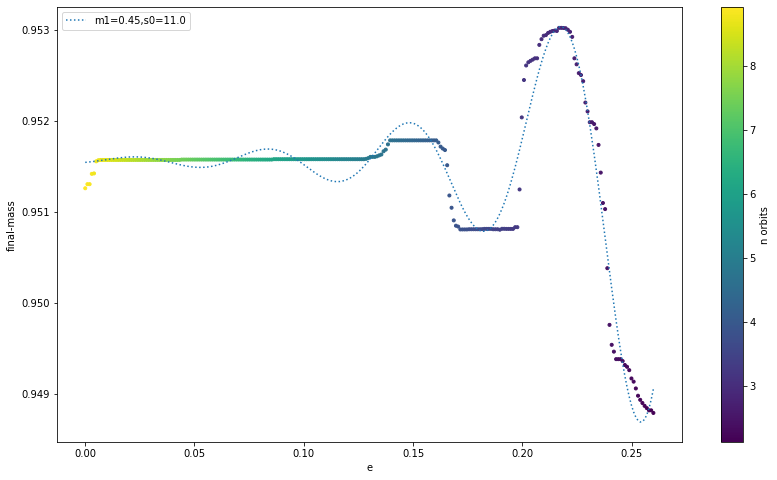

In [23]:
x_zoomed=[df_s11_m45]

k=rf_regressor.predict(df_s11_m45[df_s11_m45['e']==0])[0]
guess = {'amplitude':7.6286e-05,'f1':-245.331354,'f2':317.499654,'phase':86.8443,'decay':10.5249962,'k':k}
guesses=[guess]

for i in range(len(x_zoomed)):
    best_value_param=plot_with_fit(x_zoomed[i],poly2_damped_oscillator,guesses[i])#,name_to_save='fit_RFprediction_m_0.45_s0_11'

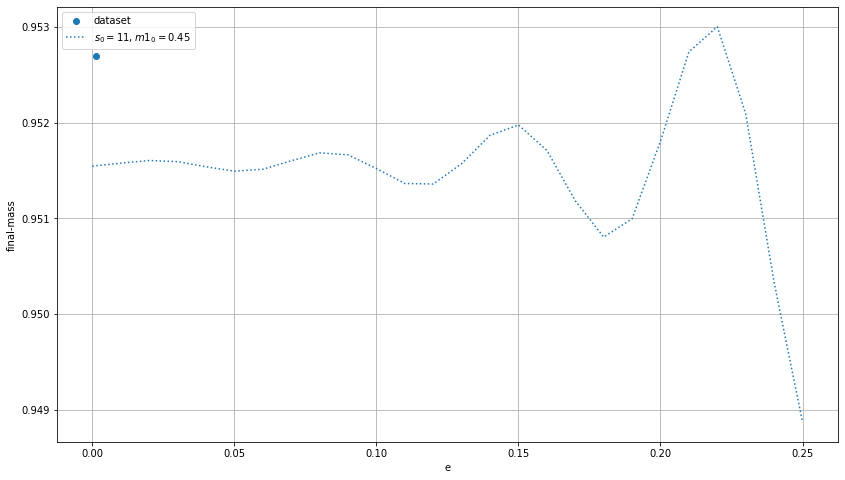

In [24]:
test_df=real_data[round(real_data['initial_m1'],2)==0.45]
# test_df=test_df[test_df['e']<=0.26]
check_with_real_data(test_df,poly2_damped_oscillator,best_value_param,name_to_save='prediction_s11_from_m1_0.43_to_0.45')